In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import requests
import matplotlib.pyplot as plt

**Mounted drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Helper Function**

In [2]:
def _downloadImage(url):
  resp = requests.get(url)
  img = np.asarray(bytearray(resp.content), dtype="uint8")
  img = cv2.imdecode(img, cv2.IMREAD_COLOR)
  return img

def _drawBoundingBox(img, cnt):
  x,y,w,h = cv2.boundingRect(cnt)
  img = cv2.rectangle(img, (x,y),(x+w,y+h),(0,255,0),2)
  return img

def _cropImage(x1, y1, x2, y2, img):
  if np.ndim(img) == 3:
    crop = img[y1:y2, x1:x2, :]
  else:
    crop = img[y1:y2, x1:x2]
  return crop

**Preprocessing**

In [3]:
#url = '/content/drive/MyDrive/Đồ án AI - OCR /code/image retrivial/license_plate_1.jpg'
url1 = '/content/drive/MyDrive/Đồ án AI - OCR /code/image retrivial/License_plate_Vietnam_Hanoi.jpg'
img = cv2.imread(url1)

In [4]:
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, imgBi = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
imgGrayBi = cv2.cvtColor(imgBi, cv2.COLOR_BGR2GRAY)

#SHOW
plt.figure(figsize=(16, 4))
plt.subplot(141), plt.imshow(img), plt.title('Origin Image')
plt.subplot(142), plt.imshow(imgGray), plt.title('Gray Image')
plt.subplot(143), plt.imshow(imgBi), plt.title('Binary Image')
plt.subplot(144), plt.imshow(imgGrayBi), plt.title('Gray of Binary Image')

error: ignored

In [ ]:
contours, _ = cv2.findContours(imgGrayBi, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
area_cnt = [cv2.contourArea(cnt) for cnt in contours]
area_sort = np.argsort(area_cnt)[::-1][:12]
# median = np.argsort(area_cnt)[::-1][len(contours)//2]

**Remove box bounding (background box)**

In [ ]:
#algorithm 1:
save = 1
for i in area_sort[1:]:
    # print(area_cnt[area_sort[save - 1]], area_cnt[area_sort[save]])
    if area_cnt[area_sort[save - 1]] // area_cnt[area_sort[save]] > 9:
       break
    else:
       save += 1

print(save)

3


In [ ]:
area_sort = area_sort[save:]

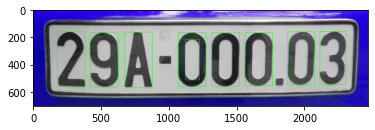

In [ ]:
imgOrigin = img.copy()
for i in area_sort:   
    cnt = contours[i]
    imgOrigin = _drawBoundingBox(imgOrigin, cnt)
  
plt.imshow(imgOrigin)

**Non-max-suppression**

In [ ]:
def non_max_suppression(boxes, overlapThresh):
    if len(boxes)==0:
       return []

    if boxes.dtype.kind == "i":
      boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        iou = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],np.where(iou > overlapThresh)[0])))

    return boxes[pick].astype("int")

In [ ]:
boundingBoxes = []
for i in area_sort:
  cnt = contours[i]
  x,y,w,h = cv2.boundingRect(cnt)
  x1, y1, x2, y2 = x, y, x+w, y+h
  boundingBoxes.append((x1, y1, x2, y2))

boundingBoxes = [box for box in boundingBoxes]
boundingBoxes = np.array(boundingBoxes)
pick = non_max_suppression(boundingBoxes, 0.5)

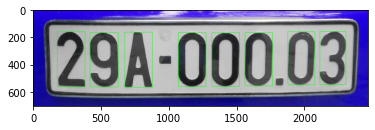

In [ ]:
imgOrigin = img.copy()
for (startX, startY, endX, endY) in pick:
    imgOrigin = cv2.rectangle(imgOrigin, (startX, startY), (endX, endY), (0, 255, 0), 2)
plt.imshow(imgOrigin)

In [ ]:
pick = sorted(pick,key = lambda x : x[0] * x[1])

In [ ]:
pick

[array([178, 159, 383, 562]),
 array([420, 165, 628, 564]),
 array([676, 162, 878, 566]),
 array([1070,  165, 1274,  562]),
 array([1317,  166, 1521,  560]),
 array([1561,  166, 1765,  556]),
 array([1877,  159, 2076,  548]),
 array([2113,  157, 2305,  546])]

In [ ]:
pick = [e for e in pick if imgOrigin.shape[0]/abs(e[0] - e[2]) > 2 and imgOrigin.shape[1]/abs(e[1] - e[3]) > 2]

In [ ]:
pick

[array([178, 159, 383, 562]),
 array([420, 165, 628, 564]),
 array([676, 162, 878, 566]),
 array([1070,  165, 1274,  562]),
 array([1317,  166, 1521,  560]),
 array([1561,  166, 1765,  556]),
 array([1877,  159, 2076,  548]),
 array([2113,  157, 2305,  546])]

In [ ]:
peak = []
candidate = pick[0][0]
for i in range(1,len(pick)):
    if pick[i][0] < candidate:
       peak.append(i)
    candidate = pick[i][0]

In [ ]:
peak

[]

In [ ]:
if len(peak) > 1:
   row2 = peak[:-1]
   pick_const = [e for i,e in enumerate(pick) if i not in row2 and i < peak[-1]]
   pick_alternate = [pick[i] for i in row2]
   
   pick = pick_const + pick_alternate + pick[peak[-1]:]

In [ ]:
crop_images = [_cropImage(x1, y1, x2, y2, img) for (x1, y1, x2, y2) in pick]

fg, ax = plt.subplots(2,4,figsize=(12, 4))
fg.suptitle('Cropped Images')

idx = 0
for i in np.arange(2):
  for j in np.arange(4):
    try:
      ax[i,j].imshow(crop_images[idx])
      ax[i,j].set_xlabel('Sub Image '+str(idx))
      idx += 1
    except:
      next

NameError: ignored